# KNN Classification using GIST Features

## Initial Setup

In [1]:
from __future__ import division
from PIL import Image
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import gist
import imageutils

%matplotlib inline
#plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
#plt.rcParams['image.interpolation'] = 'nearest'
#plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

## Load Images into a Matrix

In [2]:
base_dir = 'square_images128_traintest'
#(X_all, y_all, classes, class_dict) = imageutils.load_data(base_dir)
(X_train, y_train, classes, class_dict) = imageutils.load_data(base_dir + '/train')
(X_test, y_test, _, _) = imageutils.load_data(base_dir + '/test')
image_height = X_train.shape[1]
image_width = X_train.shape[2]
print(X_train.shape)
print(classes)

(1020, 128, 128, 3)
['bluebell', 'buttercup', 'colts_foot', 'cowslip', 'crocus', 'daffodil', 'daisy', 'dandelion', 'fritillary', 'iris', 'lily_valley', 'pansy', 'snowdrop', 'sunflower', 'tigerlily', 'tulip', 'windflower']


In [3]:
def extract_all_gist_features(X):
    num_examples = X.shape[0]
    features = []
    for index in range(num_examples):
        feature_vec = gist.extract(X[index].astype('uint8'))
        features.append(feature_vec)
    
    X_features = np.vstack(features)
    return X_features

In [4]:
def extract_gist(I):
    return gist.extract(I.astype('uint8'))

In [5]:
def tiny_image(image_array, width=16, height=16):
    I = Image.fromarray(image_array.astype('uint8'))
    I_tiny = I.resize((width, height))
    I_tiny_array = np.array(I_tiny).astype('float')
    return np.reshape(I_tiny_array, width * height * 3)

In [6]:
def color_histogram_rgb(image_array):
    h, edges = np.histogramdd(image_array.reshape(-1,3), 8, normed=True, range=[(0,255), (0,255), (0,255)])
    return h.flatten()

In [7]:
color_histogram_rgb(X_train[0]).shape

(512,)

In [8]:
def extract_features(X, feature_functions):
    num_examples = X.shape[0]
    feature_rows = []
    for index in range(num_examples):
        I = X[index]
        features = []
        for feature_func in feature_functions:
            feature_vec = feature_func(I)
            features.append(feature_vec)
        
        example_features_row_vec = np.hstack(features)
        feature_rows.append(example_features_row_vec)
    
    X_features = np.vstack(feature_rows)
    return X_features

In [9]:
from features import hog_feature, color_histogram_hsv

num_color_bins = 150 # Number of bins in the color histogram
#feature_fns = [extract_gist, hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]
#feature_fns = [extract_gist, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]
#feature_fns = [hog_feature]
#feature_fns = [lambda img: color_histogram_hsv(img, nbin=num_color_bins)]
#feature_fns = [extract_gist, tiny_image]
feature_fns = [extract_gist, tiny_image, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]
X_train_features = extract_features(X_train, feature_fns)
X_test_features = extract_features(X_test, feature_fns)

# Preprocessing: Subtract the mean feature
mean_features = np.mean(X_train_features, axis=0)
mean_features = np.expand_dims(mean_features, axis=0)
X_train_features -= mean_features
X_test_features -= mean_features

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_features = np.std(X_train_features, axis=0)
std_features = np.expand_dims(std_features, axis=0)
X_train_features /= std_features
X_test_features /= std_features

# Preprocessing: Add a bias dimension
X_train_features = np.hstack([X_train_features, np.ones((X_train_features.shape[0], 1))])
X_test_features = np.hstack([X_test_features, np.ones((X_test_features.shape[0], 1))])

print(X_train_features.shape)

(1020, 1303)


In [10]:
from sklearn.neighbors import KNeighborsClassifier

# This does 1-nearest-neighbour with L1 distance
clf = KNeighborsClassifier(n_neighbors=1, p=1, weights='uniform')
clf.fit(X_train_features, y_train)
y_pred = clf.predict(X_test_features)
accuracy = np.mean(y_pred == y_test)
print("accuracy: {0}".format(accuracy))

accuracy: 0.541176470588


## Plot a Confusion Matrix to Show Performance of KNN

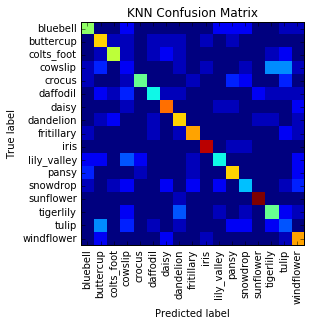

In [11]:
from sklearn.metrics import confusion_matrix
confusion = confusion_matrix(y_test, y_pred)
plt.imshow(confusion, interpolation='nearest')
tick_marks = np.arange(len(classes))
plt.title('KNN Confusion Matrix')
plt.xticks(tick_marks, classes, rotation=90)
plt.yticks(tick_marks, classes)
plt.ylabel('True label')
plt.xlabel('Predicted label')